## Land use classification
In this project, we will be using images from NASA/USGS's Landsat project to classify what is in satellite images. Thanks to UC Merced for making this data available.




In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the label map
with open('/content/drive/MyDrive/land-use-classification/data/label_map.json', 'r') as f:
    label_map = json.load(f)

In [3]:
# Define the paths to the image directories and CSV files
train_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/train'
val_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/validation'
test_dir = '/content/drive/MyDrive/land-use-classification/data/images_train_test_val/test'

train_csv = '/content/drive/MyDrive/land-use-classification/data/train.csv'
val_csv = '/content/drive/MyDrive/land-use-classification/data/validation.csv'
test_csv = '/content/drive/MyDrive/land-use-classification/data/test.csv'

In [4]:
# Load the CSV files into Pandas dataframes
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

In [5]:
# Define the image size and batch size
IMG_SIZE = 256
BATCH_SIZE = 32

We have 21 classes and 500 images in each class. We will use augmentation to create more data.

In [6]:
# Augment training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Define image data generators using ImageDataGenerator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=train_dir,
                                                    x_col='Filename',
                                                    y_col='ClassName',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(val_df,
                                                directory=val_dir,
                                                x_col='Filename',
                                                y_col='ClassName',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory=test_dir,
                                                  x_col='Filename',
                                                  y_col='ClassName',
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 7350 validated image filenames belonging to 21 classes.
Found 2100 validated image filenames belonging to 21 classes.
Found 1050 validated image filenames belonging to 21 classes.


Many different shapes of CNN were tried, we only kept a few for brevity's sake.

In [7]:
# Define a baseline CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(label_map), activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Fit the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_df)//BATCH_SIZE,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_df)//BATCH_SIZE)

Epoch 1/20
229/229 [==============================] - 2375s 10s/step - loss: 2.8164 - accuracy: 0.1155 - val_loss: 2.4579 - val_accuracy: 0.2125
Epoch 2/20
229/229 [==============================] - 128s 560ms/step - loss: 2.1528 - accuracy: 0.3040 - val_loss: 1.6782 - val_accuracy: 0.4409
Epoch 3/20
229/229 [==============================] - 129s 562ms/step - loss: 1.7218 - accuracy: 0.4388 - val_loss: 1.4766 - val_accuracy: 0.5091
Epoch 4/20
229/229 [==============================] - 128s 559ms/step - loss: 1.4560 - accuracy: 0.5180 - val_loss: 1.2900 - val_accuracy: 0.5760
Epoch 5/20
229/229 [==============================] - 128s 560ms/step - loss: 1.2668 - accuracy: 0.5795 - val_loss: 1.0194 - val_accuracy: 0.6543
Epoch 6/20
229/229 [==============================] - 130s 567ms/step - loss: 1.1530 - accuracy: 0.6181 - val_loss: 0.9492 - val_accuracy: 0.6885
Epoch 7/20
229/229 [==============================] - 129s 564ms/step - loss: 1.0308 - accuracy: 0.6536 - val_loss: 0.9116 - 

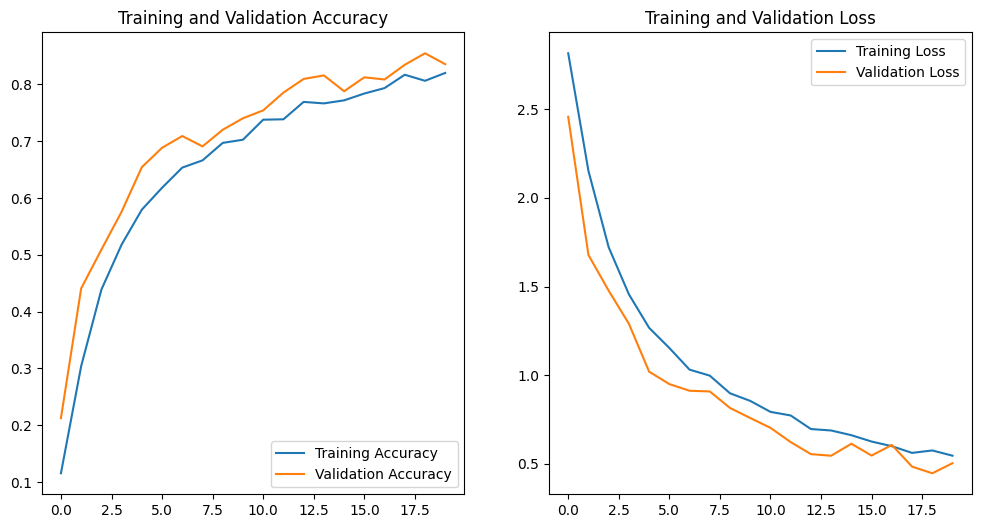

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_df)//BATCH_SIZE)
print('Test accuracy:', test_acc)

32/32 [==============================] - 239s 8s/step - loss: 0.4964 - accuracy: 0.8369
Test accuracy: 0.8369140625


That did pretty good, we'll see if we can improve on that with a different shape.

In [12]:
# See If we can improve the CNN model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(21, activation='softmax')
])

In [13]:
# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Try to speed things up
BATCH_SIZE=50

# Fit the model
history_2 = model_2.fit(train_generator,
                    steps_per_epoch=len(train_df)//BATCH_SIZE,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_df)//BATCH_SIZE)

Epoch 1/20
147/147 [==============================] - 89s 568ms/step - loss: 3.0479 - accuracy: 0.0530 - val_loss: 3.0451 - val_accuracy: 0.0461
Epoch 2/20
147/147 [==============================] - 83s 564ms/step - loss: 3.0457 - accuracy: 0.0519 - val_loss: 3.0443 - val_accuracy: 0.0543
Epoch 3/20
147/147 [==============================] - 83s 566ms/step - loss: 3.0450 - accuracy: 0.0453 - val_loss: 3.0444 - val_accuracy: 0.0506
Epoch 4/20
147/147 [==============================] - 83s 564ms/step - loss: 3.0449 - accuracy: 0.0439 - val_loss: 3.0444 - val_accuracy: 0.0476
Epoch 5/20
147/147 [==============================] - 83s 563ms/step - loss: 3.0449 - accuracy: 0.0456 - val_loss: 3.0447 - val_accuracy: 0.0439
Epoch 6/20
147/147 [==============================] - 83s 564ms/step - loss: 3.0450 - accuracy: 0.0429 - val_loss: 3.0447 - val_accuracy: 0.0461
Epoch 7/20
147/147 [==============================] - 83s 563ms/step - loss: 3.0453 - accuracy: 0.0442 - val_loss: 3.0447 - val_ac

In [15]:
test_loss, test_acc = model_2.evaluate_generator(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

<ipython-input-15-78226172828a>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_2.evaluate_generator(test_generator, steps=len(test_generator))


Test accuracy: 0.17523810267448425


Next we'll try ResNet50, a 50 layer CNN developed in 2015. It has a very good reputation.

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model_3():
    # Load the ResNet50 model, pre-trained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add new classification layers on top of the pre-trained layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(21, activation='softmax')(x)
    
    # Define the model to train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [23]:
model_3 = create_model_3()
history_3 = model_3.fit(train_generator,
                        epochs=10,
                        validation_data=val_generator)

Epoch 1/10
230/230 [==============================] - 135s 566ms/step - loss: 3.0035 - accuracy: 0.0795 - val_loss: 2.8198 - val_accuracy: 0.0986
Epoch 2/10
230/230 [==============================] - 130s 563ms/step - loss: 2.8164 - accuracy: 0.1068 - val_loss: 2.6818 - val_accuracy: 0.1490
Epoch 3/10
230/230 [==============================] - 129s 561ms/step - loss: 2.7368 - accuracy: 0.1173 - val_loss: 2.5958 - val_accuracy: 0.1395
Epoch 4/10
230/230 [==============================] - 130s 564ms/step - loss: 2.6925 - accuracy: 0.1196 - val_loss: 2.5523 - val_accuracy: 0.1919
Epoch 5/10
230/230 [==============================] - 129s 563ms/step - loss: 2.6627 - accuracy: 0.1322 - val_loss: 2.5005 - val_accuracy: 0.1905
Epoch 6/10
230/230 [==============================] - 130s 564ms/step - loss: 2.6399 - accuracy: 0.1328 - val_loss: 2.5072 - val_accuracy: 0.1700
Epoch 7/10
230/230 [==============================] - 130s 566ms/step - loss: 2.6227 - accuracy: 0.1356 - val_loss: 2.4733 -

In [24]:
test_loss, test_acc = model_3.evaluate_generator(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

<ipython-input-24-d8db4e7cd41e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_3.evaluate_generator(test_generator, steps=len(test_generator))


Test accuracy: 0.201904758810997
